# Modele analizy danych

Tomasz Rodak

---

## Optuna

Celem tego arkusza jest zapoznanie się z biblioteką [Optuna](https://optuna.org/). Jest to biblioteka automatyzująca proces optymalizacji funkcji o wartościach rzeczywistych (czyli proces znajdowania minimum lub maksimum lokalnego funkcji). W praktyce Optuna jest typowo stosowana do optymalizacji hiperparametrów modeli uczenia maszynowego.

Podstawowe obiekty definiowane w Optuna to:
- **`Study`** - obiekt reprezentujący proces optymalizacji funkcji celu, składa się na niego wiele prób.
- **`Trial`** - próba, obiekt reprezentujący pojedyńcze obliczenie wartości funkcji celu.

### Przykład
<!-- y = np.exp(np.sin(x**2)) + x**2/5 - x
 -->
Wyznaczymy minimum funkcji lokalne funkcji
$$
f(x) = \exp\sin x^2 + \frac{x^2}{5} - x
$$
na przedziale $x \in [-5, 5]$.

Wykres:

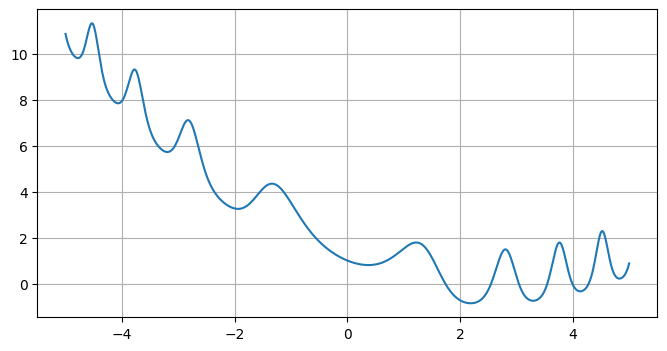

In [3]:
import matplotlib.pyplot as plt
import numpy as np

x = np.linspace(-5, 5, 1000)
y = np.exp(np.sin(x**2)) + x**2/5 - x
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(x, y)
ax.grid();

In [2]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 404.7/404.7 kB 7.8 MB/s eta 0:00:00


Optymalizacja w Optunie:

In [29]:
import optuna

a, b = -5, 5

def objective(trial):
    x = trial.suggest_float('x', a, b)
    return np.exp(np.sin(x**2)) + x**2/5 - x

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)

[I 2025-12-01 17:31:50,534] A new study created in memory with name: no-name-ce4f110c-6472-451f-b579-7b57268cb787
[I 2025-12-01 17:31:50,537] Trial 0 finished with value: 1.0694425399536036 and parameters: {'x': 2.907085212785092}. Best is trial 0 with value: 1.0694425399536036.
[I 2025-12-01 17:31:50,538] Trial 1 finished with value: 8.122619867734485 and parameters: {'x': -3.6363760645097676}. Best is trial 0 with value: 1.0694425399536036.
[I 2025-12-01 17:31:50,538] Trial 2 finished with value: 3.9205347592309603 and parameters: {'x': -1.574385265951065}. Best is trial 0 with value: 1.0694425399536036.
[I 2025-12-01 17:31:50,540] Trial 3 finished with value: 6.577876687813234 and parameters: {'x': -3.4849076419063554}. Best is trial 0 with value: 1.0694425399536036.
[I 2025-12-01 17:31:50,541] Trial 4 finished with value: 0.9040210900130523 and parameters: {'x': 4.384688848100568}. Best is trial 4 with value: 0.9040210900130523.
[I 2025-12-01 17:31:50,543] Trial 5 finished with val

Funkcja `objective()` gra rolę funkcji celu, której wartość ma być (w tym przypadku) minimalizowana. Funkcja ta przyjmuje jeden argument `trial`, który jest obiektem reprezentującym pojedyńczą próbę optymalizacyjną. Wiersz

```python
x = trial.suggest_float('x', -5, 5)
```

zmusza Optunę do wskazania zmiennoprzecinkowego kandydata zmiennej `x` z przedziału $[-5, 5]$. Wskazanie to odbywa się w sposób adaptacyjny, tzn. Optuna kieruje się w sugestiach wartościami, które zostały już sprawdzone w poprzednich próbach. Wartość zmiennej `x` jest następnie przekazywana do faktycznej funkcji celu `f(x)`. Ostatecznie `objective()` zwraca wartość funkcji celu dla danego kandydata, która jest zapisywana w obiekcie `trial` i służy do oceny jakości kandydata. Ponieważ naszym celem jest minimalizacja, więc kandydat z mniejszą wartością funkcji celu jest lepszy.

Wywołanie
    
```python
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)
```

rozpoczyna proces optymalizacji. Argument `n_trials` określa liczbę prób, które mają być wykonane. Argument `direction` określa kierunek optymalizacji, w tym przypadku minimalizację. Po zakończeniu optymalizacji obiekt `study` zawiera wyniki optymalizacji, w tym najlepsze wartości zmiennych.

Wyniki:


In [30]:
best_trial = study.best_trial
best_x = best_trial.params['x']
best_y = best_trial.value
print(f'Best x: {best_x:.3f}, Best y: {best_y:.3f}')

Best x: 2.188, Best y: -0.862


Wszystkie próby na wykresie:

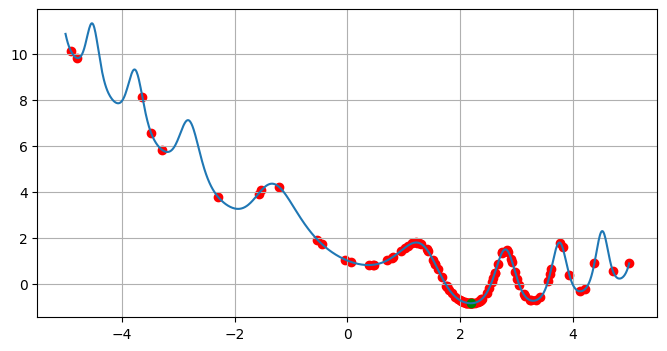

In [31]:
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(x, y)
for t in study.trials:
    ax.scatter(t.params['x'], t.value, color='red')
ax.scatter(best_x, best_y, color='green')
ax.grid();

In [32]:
import optuna.visualization as vis
vis.plot_optimization_history(study)

### Sampler

Sposób w jaki Optuna wybiera kandydatów do oceny zależy od użytego samplera. Domyślnie Optuna stosuje algorytm optymalizacji bayesowskiej z samplerem `TPESampler` (Tree-structured Parzen Estimator). Możliwe jest również użycie innych samplerów, np. `RandomSampler` czy `GridSampler`. Sampler można ustawić w wywołaniu `create_study()`.

Oto przykład użycia `GridSampler`. W tym przypadku Optuna będzie wybierać kandydatów z siatki przekazanej w argumencie `search_space` samplera. Warto zauważyć, że w przypadku `GridSampler` optymalizacja bayesowska nie ma sensu, ponieważ sprawdzane są wszystkie możliwe wartości. Aby przejść przez wszystkie punkty siatki, `n_trials` musi być ustawione na liczbę punktów w siatce. Ewentualnie można ustawić `n_trials` na `None` - wtedy optymalizacja będzie trwała dopóki nie zostaną sprawdzone wszystkie punkty siatki - lub na wartość mniejszą niż liczba punktów w siatce - wtedy optymalizacja zakończy się po sprawdzeniu `n_trials` punktów, ale może być wznawiana w przyszłości.

In [38]:
search_space = {
    'x': np.linspace(a, b, 10)
}
study = optuna.create_study(sampler=optuna.samplers.GridSampler(search_space), direction='minimize')
study.optimize(objective, n_trials=None)

[I 2025-12-01 17:39:30,941] A new study created in memory with name: no-name-116d1ed7-5e1c-43c5-8ea9-5e10e80696e0
[I 2025-12-01 17:39:30,942] Trial 0 finished with value: -0.8572234361618769 and parameters: {'x': np.float64(2.2222222222222223)}. Best is trial 0 with value: -0.8572234361618769.
[I 2025-12-01 17:39:30,944] Trial 1 finished with value: 7.547939453569711 and parameters: {'x': np.float64(8.88888888888889)}. Best is trial 0 with value: -0.8572234361618769.
[I 2025-12-01 17:39:30,946] Trial 2 finished with value: 1.6997127055804206 and parameters: {'x': np.float64(4.444444444444445)}. Best is trial 0 with value: -0.8572234361618769.
[I 2025-12-01 17:39:30,948] Trial 3 finished with value: 10.60268196590878 and parameters: {'x': np.float64(10.0)}. Best is trial 0 with value: -0.8572234361618769.
[I 2025-12-01 17:39:30,950] Trial 4 finished with value: 1.7060590445388484 and parameters: {'x': np.float64(1.1111111111111112)}. Best is trial 0 with value: -0.8572234361618769.
[I 2

In [39]:
best_trial = study.best_trial
best_x = best_trial.params['x']
best_y = best_trial.value
print(f'Best x: {best_x:.3f}, Best y: {best_y:.3f}')

Best x: 2.222, Best y: -0.857


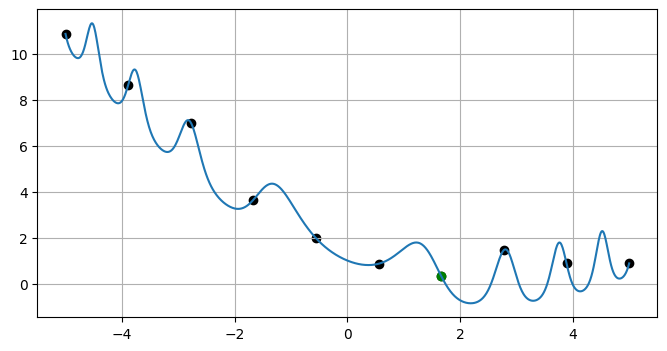

In [35]:
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(x, y)
for t in study.trials:
    ax.scatter(t.params['x'], t.value, color='black')
ax.scatter(best_x, best_y, color='green')
ax.grid();

In [40]:
optuna.visualization.plot_optimization_history(study)

### Zadanie 9.1

Funkcja Himmelblaua jest często używana do testowania algorytmów optymalizacji. Ma postać:

$$
f(x, y) = (x^2 + y - 11)^2 + (x + y^2 - 7)^2
$$

Funkcja ta posiada cztery minima lokalne:
- $f(3.0, 2.0) = 0.0$
- $f(-2.805118, 3.131312) = 0.0$
- $f(-3.779310, -3.283186) = 0.0$
- $f(3.584428, -1.848126) = 0.0$

1. Zwizualizuj funkcję Himmelblaua w zakresie $x, y \in [-5, 5]$ używając wykresu konturowego (`plt.contour` lub `plt.contourf`).

2. Użyj Optuny do znalezienia minimum funkcji.

3. Na wykresie konturowym zaznacz:
   - wszystkie próby wykonane przez Optunę (małe kropki)
   - najlepsze znalezione rozwiązanie (większy marker)
   - teoretyczne minima globalne (opcjonalnie, innym kolorem)

4. Eksperymentuj z różnymi samplerami (`TPESampler`, `RandomSampler`) i porównaj wyniki.

In [43]:
def himmelblau(x, y):
  return (x**2 + y - 11)**2 + (x + y**2 - 7)**2

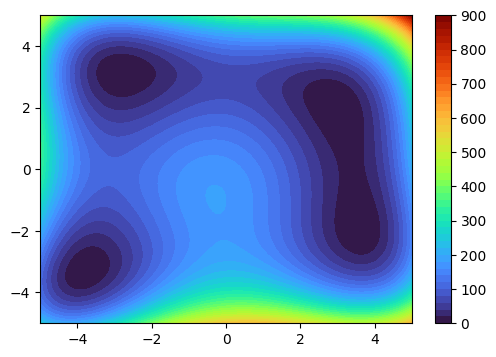

In [59]:
a, b = -5, 5
x = np.linspace(a, b, 100)
xx, yy = np.meshgrid(x, x)
zz = himmelblau(xx, yy)

plt.figure(figsize=(6, 4))
contour = plt.contourf(xx, yy, zz, levels=50, cmap='turbo')
plt.colorbar(contour)
plt.show()

In [81]:
def objective(trial):
    x = trial.suggest_float('x', a, b)
    y = trial.suggest_float('y', a, b)
    return himmelblau(x, y)

sampler = optuna.samplers.TPESampler()

study = optuna.create_study(sampler=sampler, direction='minimize')
study.optimize(objective, n_trials=200)




[I 2025-12-01 18:07:34,472] A new study created in memory with name: no-name-1efeb808-5aaa-449b-a7c7-6fc128ca46f7
[I 2025-12-01 18:07:34,481] Trial 0 finished with value: 172.52315209296668 and parameters: {'x': 2.9242096805078335, 'y': 4.135442144181567}. Best is trial 0 with value: 172.52315209296668.
[I 2025-12-01 18:07:34,483] Trial 1 finished with value: 10.021731499198761 and parameters: {'x': 3.3988949313417685, 'y': -2.4733490475783757}. Best is trial 1 with value: 10.021731499198761.
[I 2025-12-01 18:07:34,486] Trial 2 finished with value: 54.50909673032233 and parameters: {'x': -4.503840048200331, 'y': -2.8180083527935187}. Best is trial 1 with value: 10.021731499198761.
[I 2025-12-01 18:07:34,489] Trial 3 finished with value: 85.2931683631752 and parameters: {'x': -0.589928044104651, 'y': 2.0539086326824876}. Best is trial 1 with value: 10.021731499198761.
[I 2025-12-01 18:07:34,492] Trial 4 finished with value: 404.68940315862994 and parameters: {'x': -0.1018737192617909, '

In [89]:
best_trial = study.best_trial
best_x = best_trial.params['x']
best_y = best_trial.value
print(f'Best x: {best_x:.3f}, Best y: {best_y:.3f}')
best_trial.params, best_trial.value

Best x: 3.581, Best y: 0.480


({'x': 3.58144294078083, 'y': -1.6573121630237075}, 0.4801175398574674)

In [86]:
import optuna.visualization as vis
vis.plot_optimization_history(study)

In [87]:
def objective(trial):
    x = trial.suggest_float('x', a, b)
    y = trial.suggest_float('y', a, b)
    return himmelblau(x, y)

sampler = optuna.samplers.RandomSampler()

study = optuna.create_study(sampler=sampler, direction='minimize')
study.optimize(objective, n_trials=200)

[I 2025-12-01 18:09:04,296] A new study created in memory with name: no-name-aed1676d-31aa-401a-a2b8-b2e25932dcb0
[I 2025-12-01 18:09:04,298] Trial 0 finished with value: 38.273641168481724 and parameters: {'x': 2.4245835001189437, 'y': 0.596818638628922}. Best is trial 0 with value: 38.273641168481724.
[I 2025-12-01 18:09:04,302] Trial 1 finished with value: 117.26960561426529 and parameters: {'x': -2.401794463312913, 'y': -0.25100944422334415}. Best is trial 0 with value: 38.273641168481724.
[I 2025-12-01 18:09:04,303] Trial 2 finished with value: 8.001937201069405 and parameters: {'x': 3.2279418328111795, 'y': 2.431302570581911}. Best is trial 2 with value: 8.001937201069405.
[I 2025-12-01 18:09:04,305] Trial 3 finished with value: 83.87156047511604 and parameters: {'x': 0.5995719144520635, 'y': 3.479920612456631}. Best is trial 2 with value: 8.001937201069405.
[I 2025-12-01 18:09:04,306] Trial 4 finished with value: 110.49725477530174 and parameters: {'x': 1.5520269017749904, 'y': 

### Optymalizacja hiperparametrów modelu

Załóżmy, że mamy zbiór obserwacji `X` i `y` wygenerowanych z modelu

\begin{align*}
X &\sim \text{Uniform}(0, 10) \\
Y &\sim \sin(X) + \varepsilon, \quad \varepsilon \sim \mathcal{N}(0, 0.2)
\end{align*}

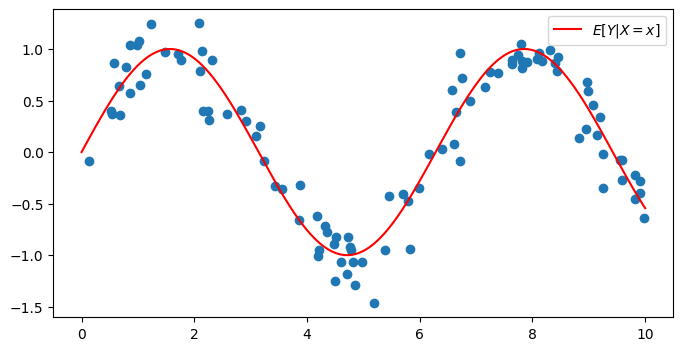

In [92]:
N = 100
a, b = 0, 10
X = np.random.uniform(a, b, N)
y = np.sin(X) + np.random.normal(0, 0.2, N)
xx = np.linspace(a, b, 1000)
fig, ax = plt.subplots(figsize=(8, 4))
ax.scatter(X, y)
ax.plot(xx, np.sin(xx), color='red', label='$E[Y|X=x]$')
ax.legend();

Naszym celem jest zbudowanie modelu regresji wielomianowej z regularyzacją L2. Model ma wówczas postać

$$
y = \sum_{i=0}^d w_i x^i
$$

gdzie $d$ to stopień wielomianu, a $w_i$ to współczynniki regresji. Regularyzacja L2 polega na dodaniu do funkcji celu kary za duże wartości współczynników:

$$
\text{RSS} + \lambda \sum_{i=0}^d w_i^2
$$

gdzie $\text{RSS}$ to suma kwadratów reszt, a $\lambda$ to współczynnik regularyzacji.

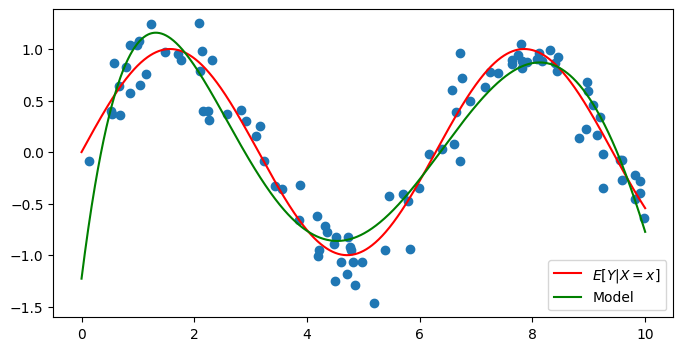

In [99]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge

model = Pipeline([
    ('poly', PolynomialFeatures(degree=5)),
    ('ridge', Ridge(alpha=1e-3))
])
model.fit(X[:, None], y)

fig, ax = plt.subplots(figsize=(8, 4))
ax.scatter(X, y)
ax.plot(xx, np.sin(xx), color='red', label='$E[Y|X=x]$')
ax.plot(xx, model.predict(xx[:, None]), color='green', label='Model')
ax.legend();

Hiperparametrami modelu są $d$ i $\lambda$. Naszym celem jest znalezienie takich wartości hiperparametrów, które minimalizują błąd testowy modelu. Przestrzeń hiperparametrów przeszukamy za pomocą Optuny, jak jednak zaimplementować funkcję celu, która powinna zwracać błąd testowy? Błąd testowy obliczamy na tej części danych, które nie były użyta do uczenia modelu. Jedna z prostszych strategii to podzielenie danych na zbiór treningowy i walidacyjny. Część treningową użyjemy do uczenia modelu, a część walidacyjną do obliczenia błędu testowego.

In [94]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.5, random_state=0)

In [95]:
def objective(trial):
    alpha = trial.suggest_float('alpha', 0, 100, log=False)
    degree = trial.suggest_int('degree', 1, 20)
    model = Pipeline([
        ('poly', PolynomialFeatures(degree=degree)),
        ('linear', Ridge(alpha=alpha))
    ])
    # test stabilności numerycznej
    XX = model.named_steps['poly'].fit_transform(X_train[:, None])
    Z = XX.T @ XX + alpha * np.eye(XX.shape[1])
    singular_values = np.linalg.svd(Z, compute_uv=False)
    rcond = np.min(singular_values) / np.max(singular_values)
    if rcond < 1e-15:
        return np.inf
    else:
        model.fit(X_train[:, None], y_train)
        y_pred = model.predict(X_val[:, None])
        test_loss = np.mean((y_val - y_pred)**2)
        return test_loss

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=200)

[I 2025-12-01 18:12:51,333] A new study created in memory with name: no-name-26dea6d0-9d37-4c3e-b0dc-5e08f54404d4
[I 2025-12-01 18:12:51,350] Trial 0 finished with value: 0.07815364431491098 and parameters: {'alpha': 64.35850925986021, 'degree': 8}. Best is trial 0 with value: 0.07815364431491098.
[I 2025-12-01 18:12:51,354] Trial 1 finished with value: inf and parameters: {'alpha': 33.575359374105275, 'degree': 20}. Best is trial 0 with value: 0.07815364431491098.
[I 2025-12-01 18:12:51,356] Trial 2 finished with value: inf and parameters: {'alpha': 3.0249852799740906, 'degree': 14}. Best is trial 0 with value: 0.07815364431491098.
[I 2025-12-01 18:12:51,365] Trial 3 finished with value: 0.11707477753647023 and parameters: {'alpha': 49.63559480317119, 'degree': 6}. Best is trial 0 with value: 0.07815364431491098.
[I 2025-12-01 18:12:51,367] Trial 4 finished with value: inf and parameters: {'alpha': 82.12317951364325, 'degree': 12}. Best is trial 0 with value: 0.07815364431491098.
[I 2

In [96]:
best_trial = study.best_trial
best_alpha = best_trial.params['alpha']
best_degree = best_trial.params['degree']
best_loss = best_trial.value
print(f'Best alpha: {best_alpha:.3f}, Best degree: {best_degree}, Best loss: {best_loss:.3f}')

Best alpha: 0.204, Best degree: 6, Best loss: 0.044


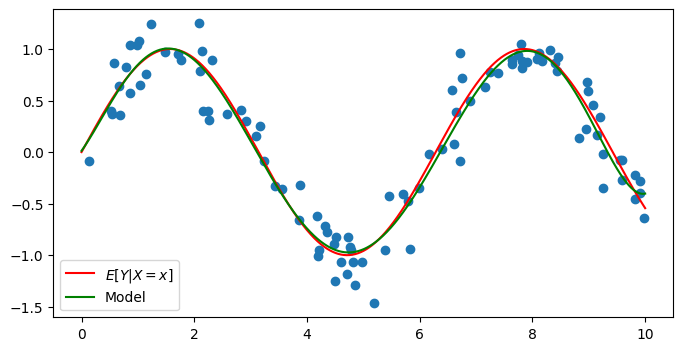

In [97]:
model = Pipeline([
    ('poly', PolynomialFeatures(degree=best_degree)),
    ('linear', Ridge(alpha=best_alpha))
])
model.fit(X[:, None], y)
yy = model.predict(xx[:, None])

fig, ax = plt.subplots(figsize=(8, 4))
ax.scatter(X, y)
ax.plot(xx, np.sin(xx), color='red', label='$E[Y|X=x]$')
ax.plot(xx, yy, color='green', label='Model')
ax.legend();

In [98]:
# visualize the optimization process in dashboard
import optuna.visualization as vis
vis.plot_optimization_history(study)